## MSA vs PSP

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.5
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')
_random_seed = 55

## 5. PSP (positive) vs MSA (negative)

In [15]:
# Get the data
data4 = group_classes(_data, {2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       302
          1       0.79      0.82      0.81        61

avg / total       0.93      0.93      0.93       363


recall	0.819672131148
precision	0.793650793651
auc	0.888312886766
specificity	0.956953642384
npv	0.963333333333
accuracy	0.933884297521


In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0267993450165	0.00258243076019
score_time	0.00910167694092	0.000664084271089
test_recall	0.807692307692	0.0758162123546
train_recall	0.937441077441	0.00940931365641
test_precision	0.742501616031	0.0238996948031
train_precision	0.908288327925	0.0340813189511
test_auc	0.871642764016	0.0371930963565
train_auc	0.957703589568	0.00882775338705
test_specificity	0.935593220339	0.00677966101695
train_specificity	0.977966101695	0.00864240595524
test_npv	0.955337386423	0.0169322832567
train_npv	0.985469399416	0.00218361810428
test_accuracy	0.911834094368	0.0140501161046
train_accuracy	0.970378006873	0.0086332218114


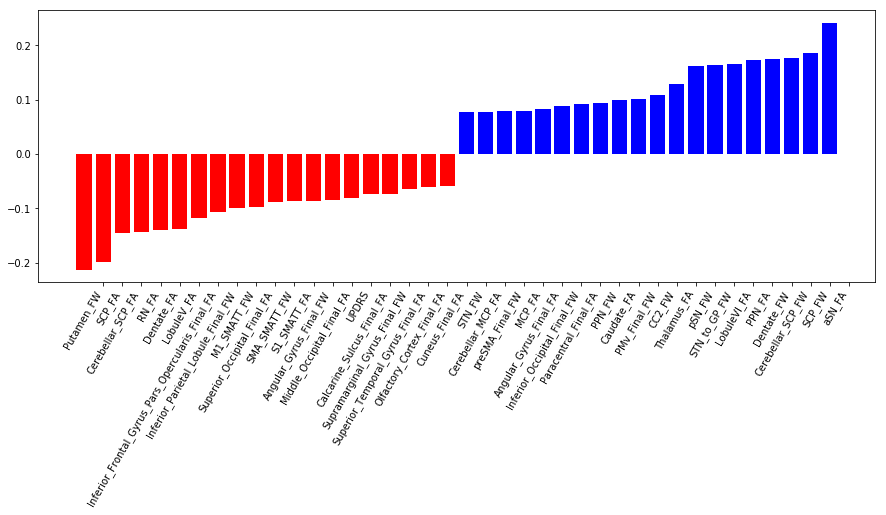

Age	0.0612443745258
Sex	0.0
UPDRS	-0.0811164237213
aSN_FA	0.241903470563
Caudate_FA	0.0990596565049
CC2_FA	-0.0418519485375
GP_FA	0.0539649872144
LobuleVI_FA	0.165534656394
LobuleV_FA	-0.137732920632
MCP_FA	0.0796042943264
pSN_FA	0.0539136703898
Putamen_FA	-0.0419374291745
SCP_FA	-0.199893763533
STN_FA	0.0202222778578
Thalamus_FA	0.129681568213
Vermis_FA	0.0674996802043
RN_FA	-0.143104096319
PPN_FA	0.173512136484
Dentate_FA	-0.140848948772
CC1_FA	-0.0156512910026
aSN_FW	0.0337494866697
Caudate_FW	0.0170080507529
CC2_FW	0.10890058398
GP_FW	-0.0372322706125
LobuleVI_FW	-0.0418445372886
LobuleV_FW	0.00950838581794
MCP_FW	0.0615344740167
pSN_FW	0.162621738023
Putamen_FW	-0.213437798444
SCP_FW	0.186916673919
STN_FW	0.0767114557362
Thalamus_FW	0.023798873104
Vermis_FW	-0.00374369259335
RN_FW	0.0278228118102
PPN_FW	0.0939245438098
Dentate_FW	0.175411266983
CC1_FW	-0.0198794329165
Angular_Gyrus_Final_FA	0.0827143742011
Anterior_Orbital_Gyrus_Final_FA	0.0150320751569
Calcarine_Sulcus_Final_FA	-

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       302
          1       0.79      0.82      0.81        61

avg / total       0.93      0.93      0.93       363



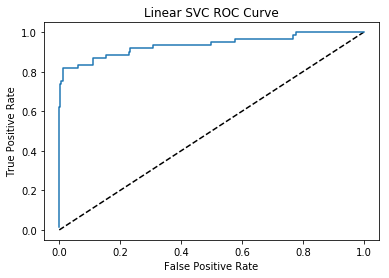

0.0 0.016393442623
0.0 0.622950819672
0.00331125827815 0.622950819672
0.00331125827815 0.737704918033
0.00662251655629 0.737704918033
0.00662251655629 0.754098360656
0.0132450331126 0.754098360656
0.0132450331126 0.819672131148
0.0629139072848 0.819672131148
0.0629139072848 0.83606557377
0.109271523179 0.83606557377
0.109271523179 0.868852459016
0.152317880795 0.868852459016
0.152317880795 0.885245901639
0.228476821192 0.885245901639
0.228476821192 0.901639344262
0.23178807947 0.901639344262
0.23178807947 0.918032786885
0.307947019868 0.918032786885
0.307947019868 0.934426229508
0.5 0.934426229508
0.5 0.950819672131
0.576158940397 0.950819672131
0.576158940397 0.967213114754
0.76821192053 0.967213114754
0.76821192053 0.983606557377
0.778145695364 0.983606557377
0.778145695364 1.0
1.0 1.0


In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 6. MSA (positive) vs PSP (negative)

In [15]:
# Get the data
data4 = group_classes(_data, {2:1, 3:0})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       302
          1       0.79      0.82      0.81        61

avg / total       0.93      0.93      0.93       363


recall	0.819672131148
precision	0.793650793651
auc	0.888312886766
specificity	0.956953642384
npv	0.963333333333
accuracy	0.933884297521


In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0267993450165	0.00258243076019
score_time	0.00910167694092	0.000664084271089
test_recall	0.807692307692	0.0758162123546
train_recall	0.937441077441	0.00940931365641
test_precision	0.742501616031	0.0238996948031
train_precision	0.908288327925	0.0340813189511
test_auc	0.871642764016	0.0371930963565
train_auc	0.957703589568	0.00882775338705
test_specificity	0.935593220339	0.00677966101695
train_specificity	0.977966101695	0.00864240595524
test_npv	0.955337386423	0.0169322832567
train_npv	0.985469399416	0.00218361810428
test_accuracy	0.911834094368	0.0140501161046
train_accuracy	0.970378006873	0.0086332218114


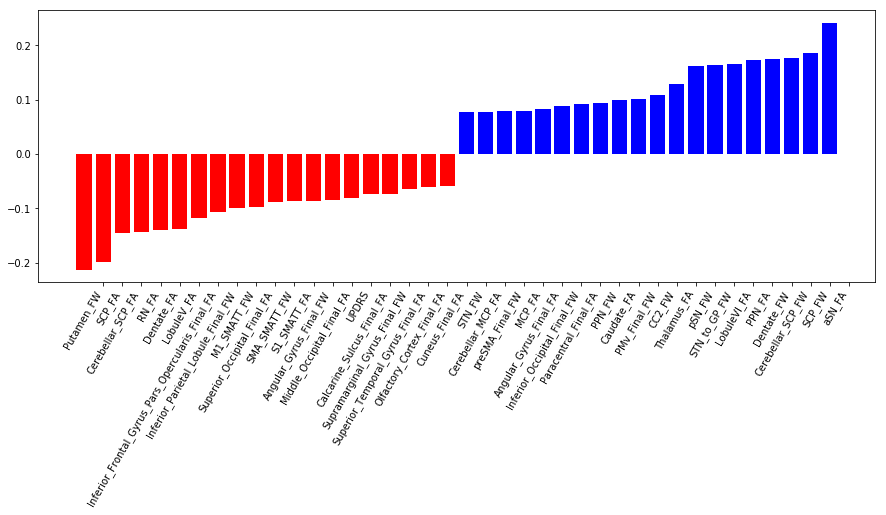

Age	0.0612443745258
Sex	0.0
UPDRS	-0.0811164237213
aSN_FA	0.241903470563
Caudate_FA	0.0990596565049
CC2_FA	-0.0418519485375
GP_FA	0.0539649872144
LobuleVI_FA	0.165534656394
LobuleV_FA	-0.137732920632
MCP_FA	0.0796042943264
pSN_FA	0.0539136703898
Putamen_FA	-0.0419374291745
SCP_FA	-0.199893763533
STN_FA	0.0202222778578
Thalamus_FA	0.129681568213
Vermis_FA	0.0674996802043
RN_FA	-0.143104096319
PPN_FA	0.173512136484
Dentate_FA	-0.140848948772
CC1_FA	-0.0156512910026
aSN_FW	0.0337494866697
Caudate_FW	0.0170080507529
CC2_FW	0.10890058398
GP_FW	-0.0372322706125
LobuleVI_FW	-0.0418445372886
LobuleV_FW	0.00950838581794
MCP_FW	0.0615344740167
pSN_FW	0.162621738023
Putamen_FW	-0.213437798444
SCP_FW	0.186916673919
STN_FW	0.0767114557362
Thalamus_FW	0.023798873104
Vermis_FW	-0.00374369259335
RN_FW	0.0278228118102
PPN_FW	0.0939245438098
Dentate_FW	0.175411266983
CC1_FW	-0.0198794329165
Angular_Gyrus_Final_FA	0.0827143742011
Anterior_Orbital_Gyrus_Final_FA	0.0150320751569
Calcarine_Sulcus_Final_FA	-

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       302
          1       0.79      0.82      0.81        61

avg / total       0.93      0.93      0.93       363



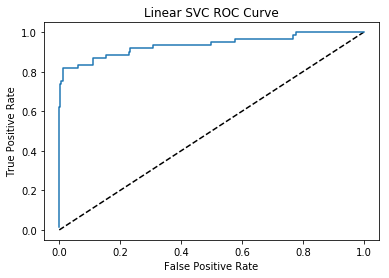

0.0 0.016393442623
0.0 0.622950819672
0.00331125827815 0.622950819672
0.00331125827815 0.737704918033
0.00662251655629 0.737704918033
0.00662251655629 0.754098360656
0.0132450331126 0.754098360656
0.0132450331126 0.819672131148
0.0629139072848 0.819672131148
0.0629139072848 0.83606557377
0.109271523179 0.83606557377
0.109271523179 0.868852459016
0.152317880795 0.868852459016
0.152317880795 0.885245901639
0.228476821192 0.885245901639
0.228476821192 0.901639344262
0.23178807947 0.901639344262
0.23178807947 0.918032786885
0.307947019868 0.918032786885
0.307947019868 0.934426229508
0.5 0.934426229508
0.5 0.950819672131
0.576158940397 0.950819672131
0.576158940397 0.967213114754
0.76821192053 0.967213114754
0.76821192053 0.983606557377
0.778145695364 0.983606557377
0.778145695364 1.0
1.0 1.0


In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)